In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.linear_model import *
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

from lineartree import LinearTreeRegressor

In [2]:
### READ DATA ###

df = pd.read_csv("SimulatedSales.csv.zip")
df.fillna(-1, inplace=True)
df.sort_values(['Store','index'], inplace=True)
df.set_index('index', inplace=True)
df.index.name = None

n_stores = df.Store.nunique()

print(df.shape)
df.head()

(362463, 9)


,Sales,Store,DayOfWeek,Month,WeekOfYear,Promo,Promo2,LocalHoliday,SchoolHoliday
0,4266,85,3,1,1,0,0,0,1
1,3478,85,4,1,1,0,0,0,0
2,4469,85,5,1,1,0,0,0,0
3,1603,85,6,1,1,0,0,0,0
4,6991,85,1,1,2,1,0,0,0


In [3]:
### GET DATA FOR SINGLE STORE ###

id_shop = 1141

X_train, X_test, y_train, y_test = train_test_split(
    df[df['Store'] == id_shop].drop('Sales', axis=1), 
    df[df['Store'] == id_shop]['Sales'], 
    test_size=0.3, shuffle=False)

X_train.shape, X_test.shape

((548, 8), (236, 8))

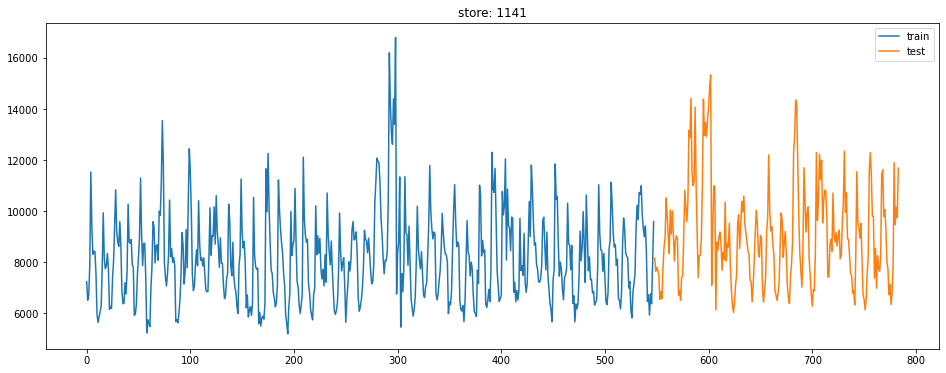

In [4]:
### PLOT STORE DATA ###

y_train.plot(label='train', figsize=(16,6))
y_test.plot(label='test')
plt.title("store: {}".format(id_shop)); plt.legend()

In [5]:
### TUNING LINEAR TREE FOR SINGLE STORE ###

model = GridSearchCV(estimator=LinearTreeRegressor(Ridge(), criterion='rmse'),
                     param_grid={'max_depth': [1, 2, 3], 'min_samples_split': [0.4, 0.3, 0.2]}, 
                     n_jobs=-1, cv=2, scoring='neg_mean_squared_error', refit=True)
model.fit(X_train, y_train)

model.best_params_

{'max_depth': 3, 'min_samples_split': 0.4}

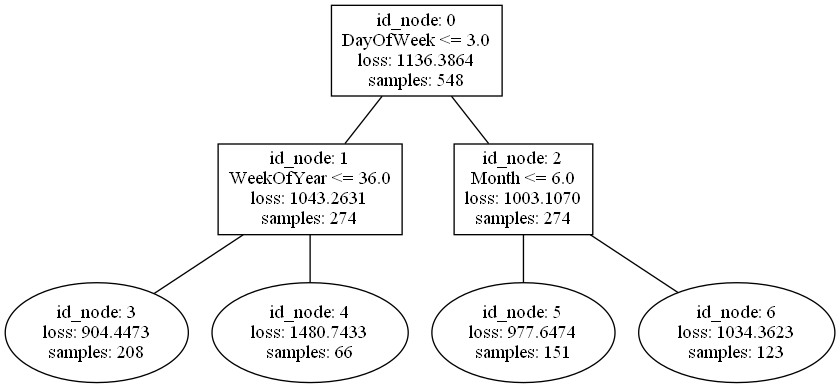

In [6]:
### PLOT MODEL DECISION PATH ###

model.best_estimator_.plot_model(feature_names=X_train.columns)

In [7]:
### COMPUTE TEST ERROR FOR LINEAR TREE ###

pred_lt = pd.Series(model.predict(X_test), index = y_test.index)
mean_squared_error(y_test, pred_lt, squared=False)

1514.4232654275215

In [8]:
### TUNING LINEAR REGRESSION FOR SINGLE STORE ###

model = GridSearchCV(estimator=Ridge(), param_grid={'alpha': [1, 3, 5, 10, 20]}, 
                     scoring='neg_mean_squared_error', cv=2, refit=True)
model.fit(X_train, y_train)

model.best_params_

{'alpha': 5}

In [9]:
### COMPUTE TEST ERROR FOR LINEAR REGRESSION ###

pred_lr = pd.Series(model.predict(X_test), index = y_test.index)
mean_squared_error(y_test, pred_lr, squared=False)

1788.0313792931413

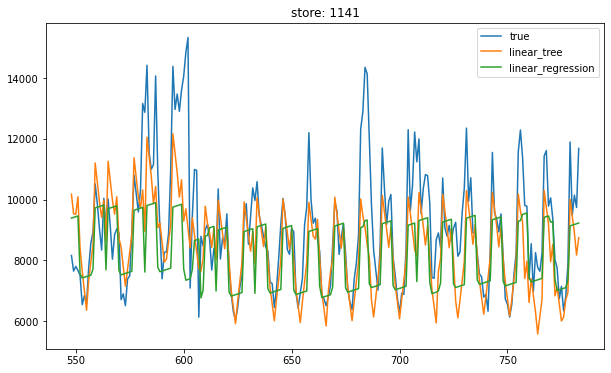

In [10]:
### PLOT AND COMPARE PREDICTIONS ON TEST SET ###

y_test.plot(label='true', figsize=(10,6))
pred_lt.plot(label='linear_tree')
pred_lr.plot(label='linear_regression')
plt.title("store: {}".format(id_shop)); plt.legend()

In [11]:
### FIT LINEAR TREE AND LINEAR REGRESSION FOR ALL THE STORE SEPARATELY ###

scores_lr = {}
scores_lt = {}
                 
for _,g_df in tqdm(df.groupby(['Store']), total=n_stores):

    _X_train, _X_test, _y_train, _y_test = train_test_split(
        g_df.drop('Sales', axis=1), g_df['Sales'], test_size=0.3, shuffle=False)
    
    model = GridSearchCV(estimator=Ridge(), param_grid={'alpha': [1, 3, 5]}, 
                         scoring='neg_mean_squared_error', cv=2, refit=True)
    model.fit(_X_train, _y_train)
    
    _pred = pd.Series(model.predict(_X_test), index = _y_test.index)
    scores_lr[_] = mean_squared_error(_y_test, _pred, squared=False)    

    model = GridSearchCV(estimator=LinearTreeRegressor(Ridge(), criterion='rmse'),
                         param_grid={'max_depth': [1, 2, 3], 'min_samples_split': [0.4, 0.3, 0.2]}, 
                         n_jobs=-1, cv=2, scoring='neg_mean_squared_error', refit=True)
    model.fit(_X_train, _y_train)
    
    _pred = pd.Series(model.predict(_X_test), index = _y_test.index)
    scores_lt[_] = mean_squared_error(_y_test, _pred, squared=False)

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [04:24<00:00,  1.51it/s]


In [12]:
### COMPARE ERRORS OF ALL THE STORES ###

compare = {}

for (store,score_lr),(store,score_lt) in zip(scores_lr.items(), scores_lt.items()):
    
    if score_lr > score_lt:
        compare[store] = 'linear tree'
    elif score_lr < score_lt:
        compare[store] = 'linear regression'
    else:
        compare[store] = 'equal'

In [13]:
### GET COMPARISON RATIO ###

pd.Series(compare).value_counts() / len(compare)

linear tree          0.9475
linear regression    0.0525
dtype: float64

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

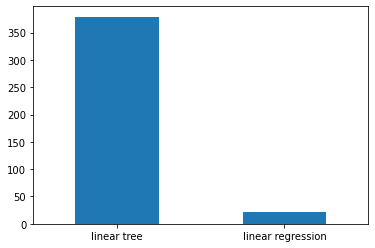

In [14]:
### PLOT PERFORMANCE ###

pd.Series(compare).value_counts().plot.bar()
plt.xticks(rotation=0)